# Презентационный проект по Методам на основе деревьев.

В этом проекте мы будем изучать отток клиентов(churn) для провайдера интернет услуг и телефонии.

**ЦЕЛЬ:** 
Создать модель предсказания того, уйдёт ли абонент в отток (churn) или нет.

**Задача 1. Исследование данных.**
Необходимо получить описание картины в общем.

**Задача 2. Анализ оттока.**
Необходимо разбить абонентов на отдельные сегменты (когорты) по длительности обслуживания.
С целью понимания изменений поведения абонентов, в зависимости от длительности обслуживания.

**Задача 3. Построение предиктивных моделей.**
Необходимо построить ряд предиктивных моделей, чтобы в дальнейшем сравнить результаты моделей и выбрать наиболее подходящую нашим данным.





**Импорт библиотек.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Импорт DataFrame.**

In [2]:
df = pd.read_csv('Tree_Methods_Project_Data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Проверка на наличие отсутствуюших значений.**

Отсутствующие значения отсутствуют во всех признаках.

In [3]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Задача 1. Исследование данных.

**Сбалансированность классов Целевой переменной.**

Видим небольшую несбалансированность классов.

In [50]:
df['Churn'].value_counts()

Churn
No     5163
Yes    1869
Name: count, dtype: int64

<Axes: xlabel='Churn', ylabel='count'>

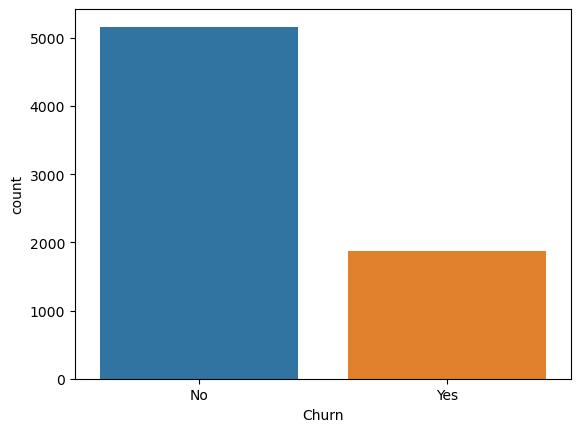

In [5]:
sns.countplot(data=df,x='Churn')

**Сбалансированность классов Признака Contract и Целевой переменной Churn.**

Видим, что классов Month-to-month, One year Contract колличество Churn==Yes, No примерно одинаковое.

Что не скажешь про класс Two year. Видим меньшее количество клиентов уходящих в отток.

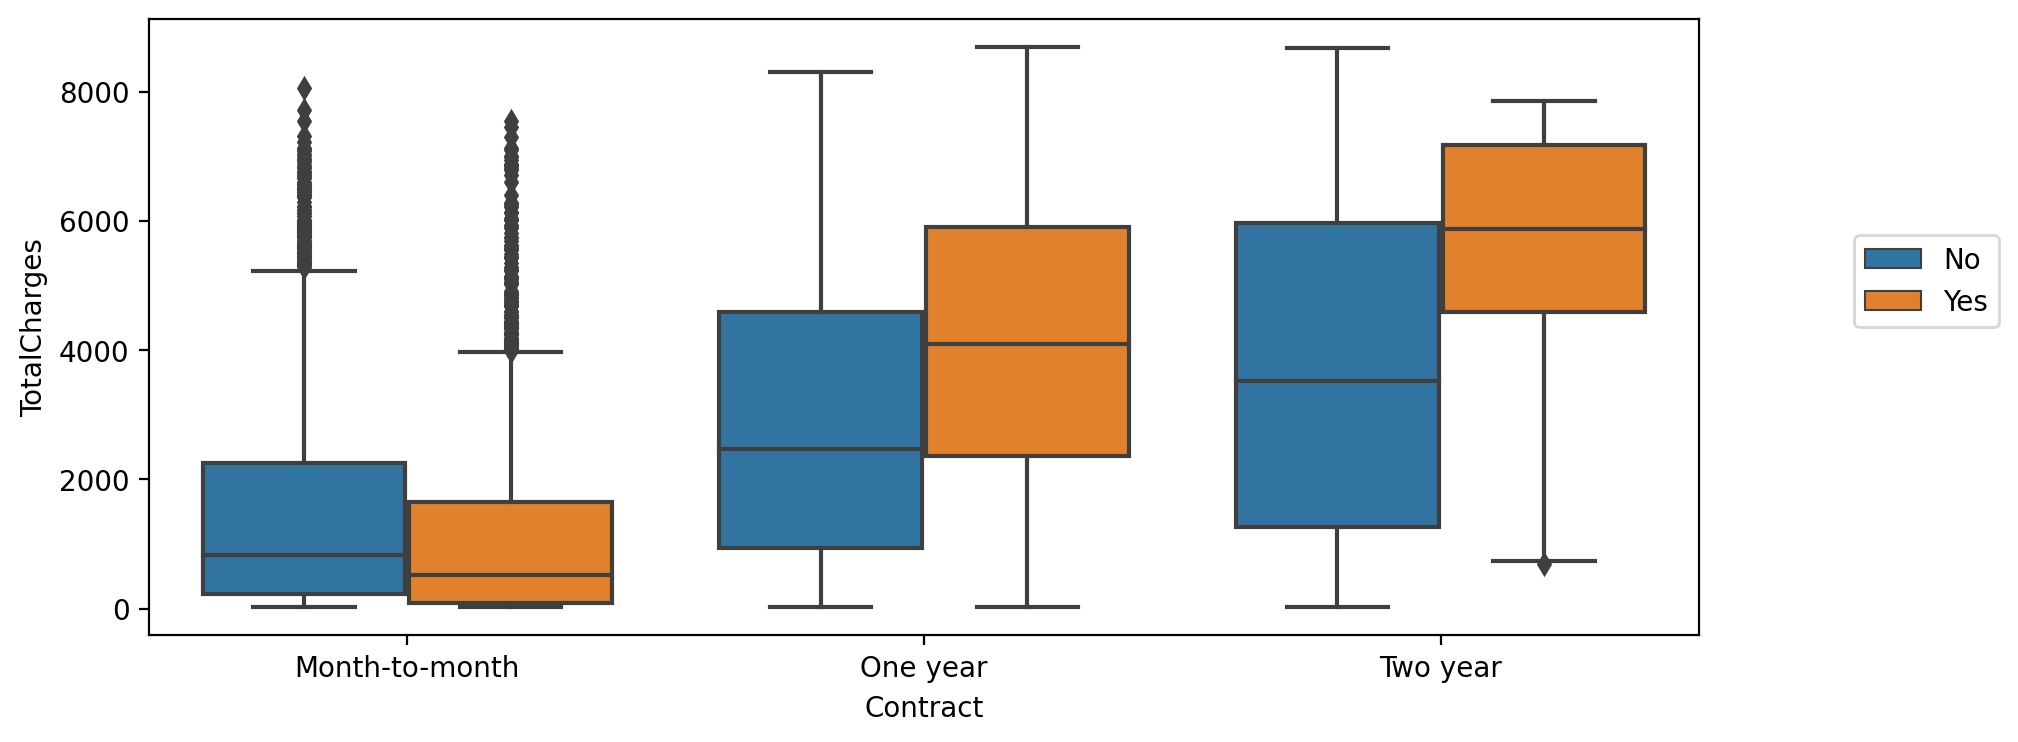

In [6]:
plt.figure(figsize=(10,4),dpi=200)
sns.boxplot(data=df,y='TotalCharges',x='Contract',hue='Churn')
plt.legend(loc=(1.1,0.5))

**Ищем корреляцию Признаков с классом Целевой Переменной Yes.**

Выявили ряд признаков имеющих корреляцию с Yes Churn

Например, если у кого-то контракт month-to-month то, это сильно коррелирует с оттоком.

Отрицательную корреляцию показывают пользователи имеющие Contract_to_year.

In [8]:
corr_df  = pd.get_dummies(df[['gender', 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod','Churn']]).corr()

In [10]:
corr_df['Churn_Yes'].sort_values().iloc[1:-1]

Contract_Two year                         -0.301552
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
TechSupport_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
OnlineBackup_No internet service          -0.227578
OnlineSecurity_No internet service        -0.227578
InternetService_No                        -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

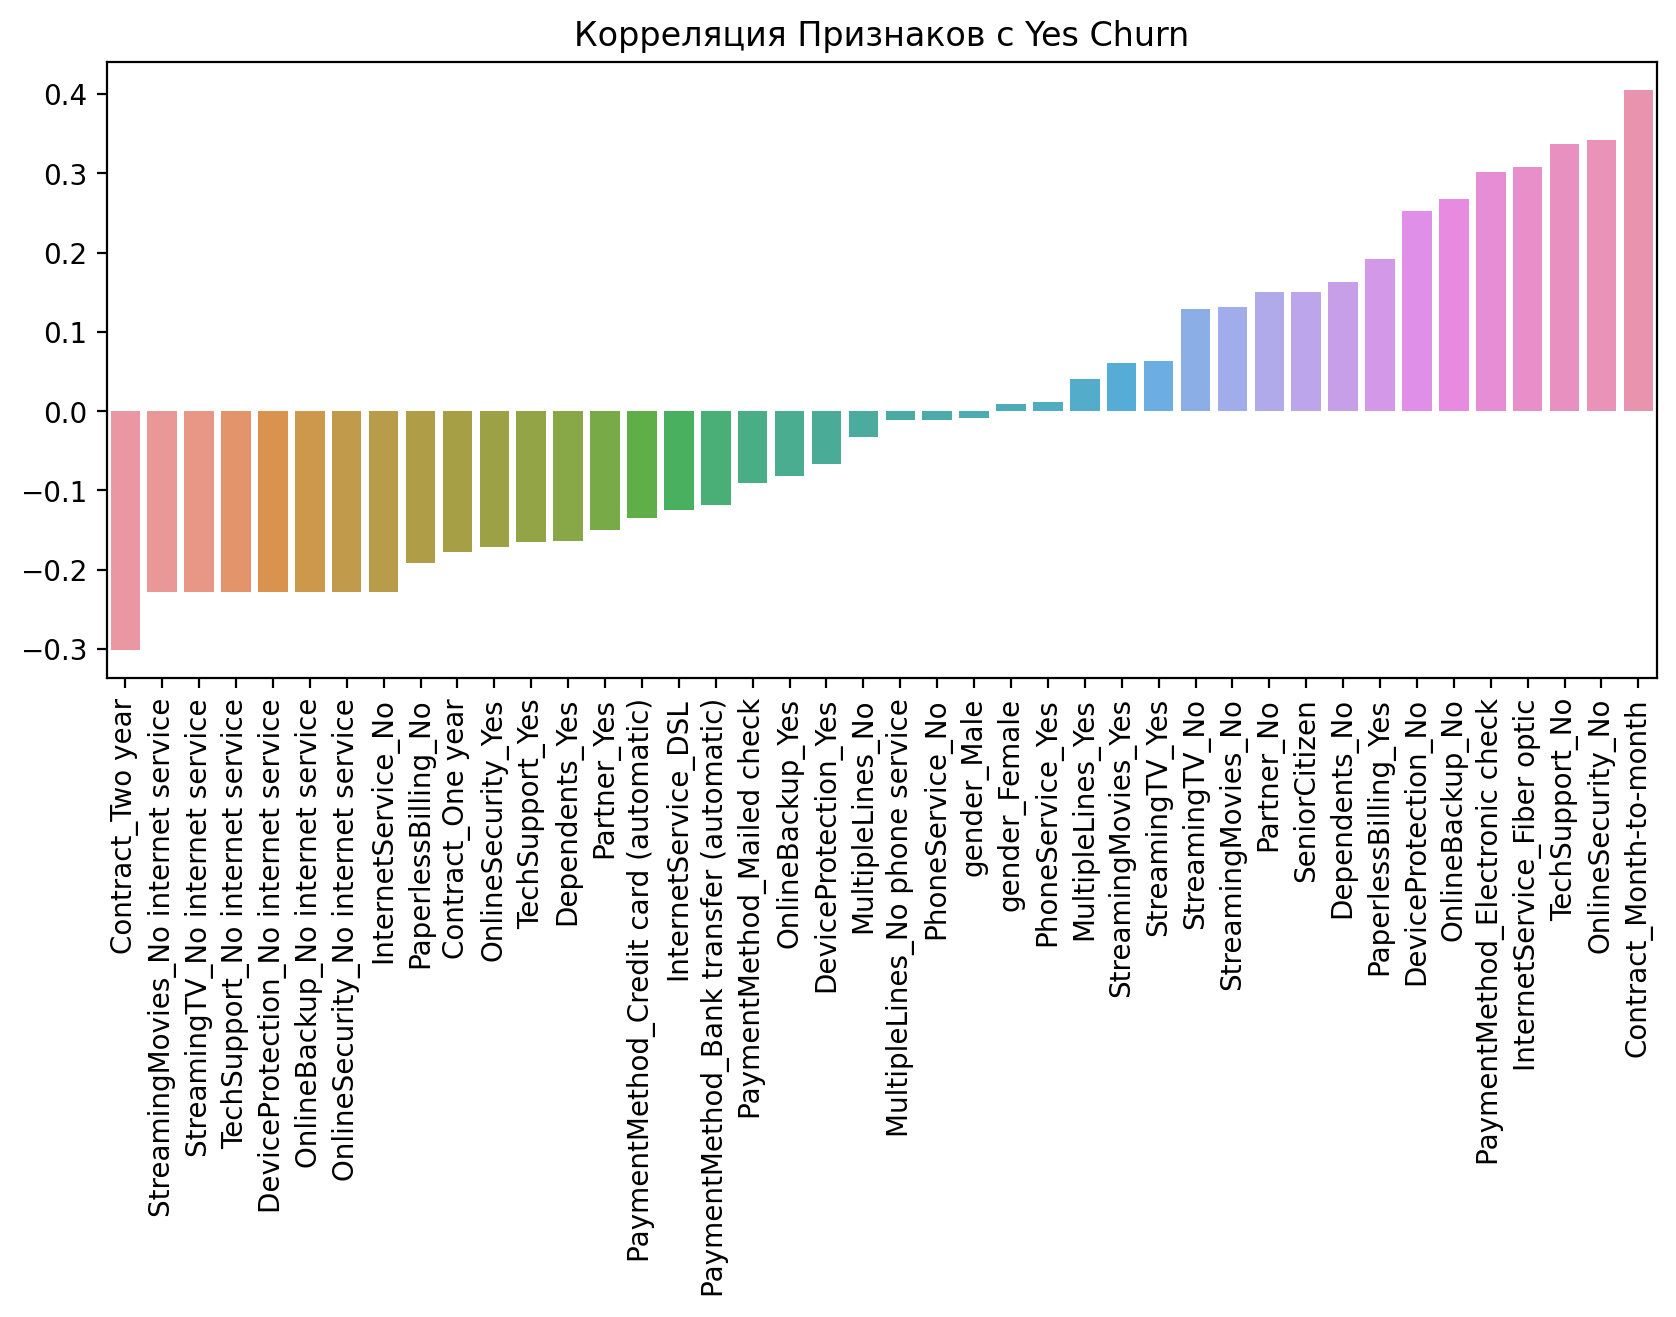

In [49]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(x=corr_df['Churn_Yes'].sort_values().iloc[1:-1].index,y=corr_df['Churn_Yes'].sort_values().iloc[1:-1].values)
plt.title("Корреляция Признаков с Yes Churn")
plt.xticks(rotation=90);

## Задача 2. Анализ оттока.

**Классы Признаков Contract, tenure.**

Выясняем типы контрактов и типы времени пользования.

In [52]:
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [53]:
df['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26, 39], dtype=int64)

**Анализ Гистограмм.**

Наблюдаем большие всплески по заключениям контрактов длительностью 1, 70 + месяцев.

Также наблюдаем, что очень мало людей уходит в отток при Одно годовых, Дву годовых контрактах.

В основном люди уходят в отток на контрактах month-to-month.

<Axes: xlabel='tenure', ylabel='Count'>

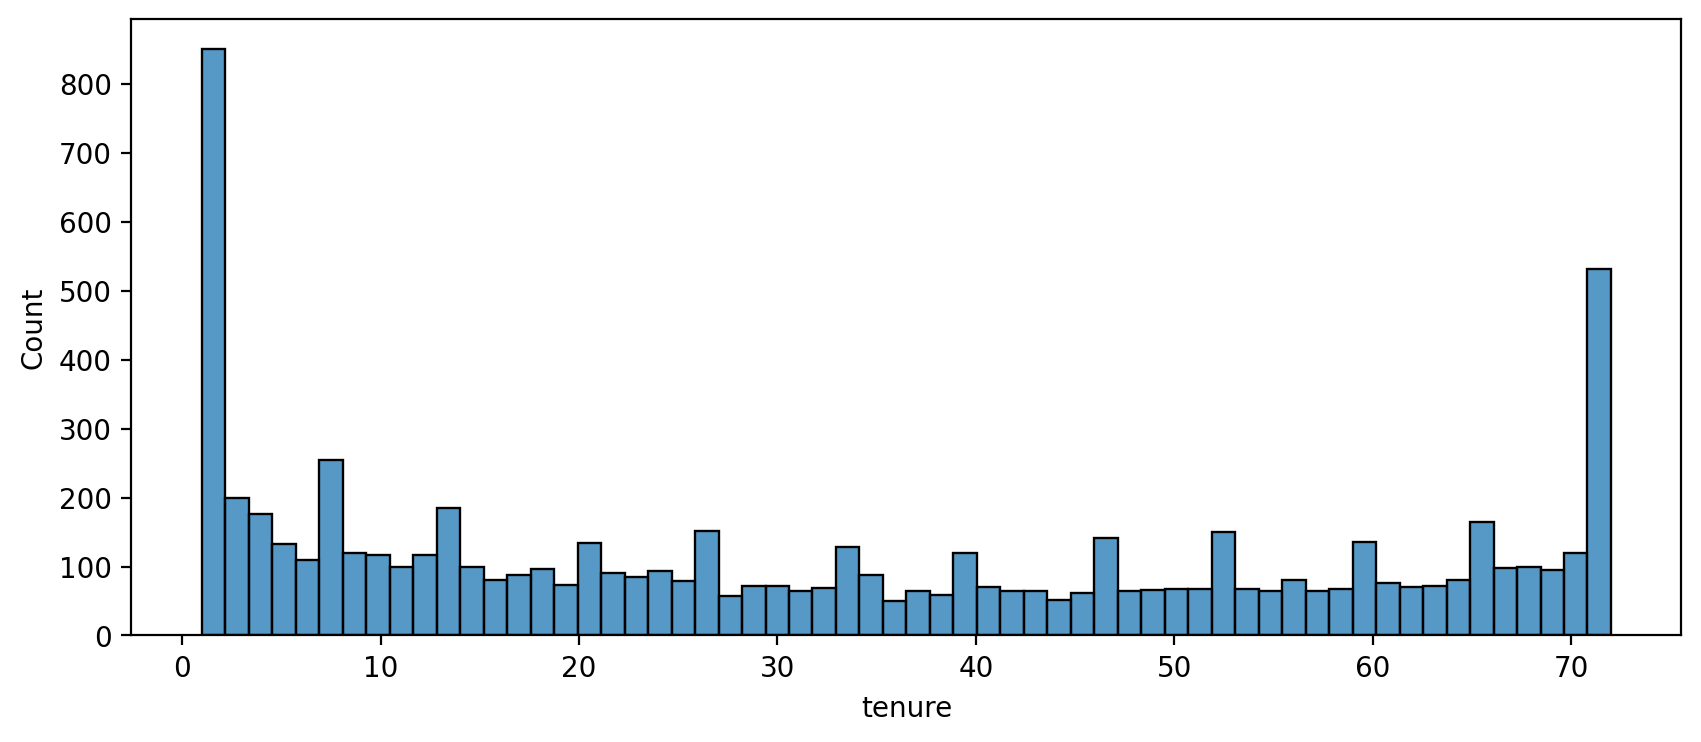

In [54]:
plt.figure(figsize=(10,4),dpi=200)
sns.histplot(data=df,x='tenure',bins=60)

C:\Users\AdminPC\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x600 with 0 Axes>

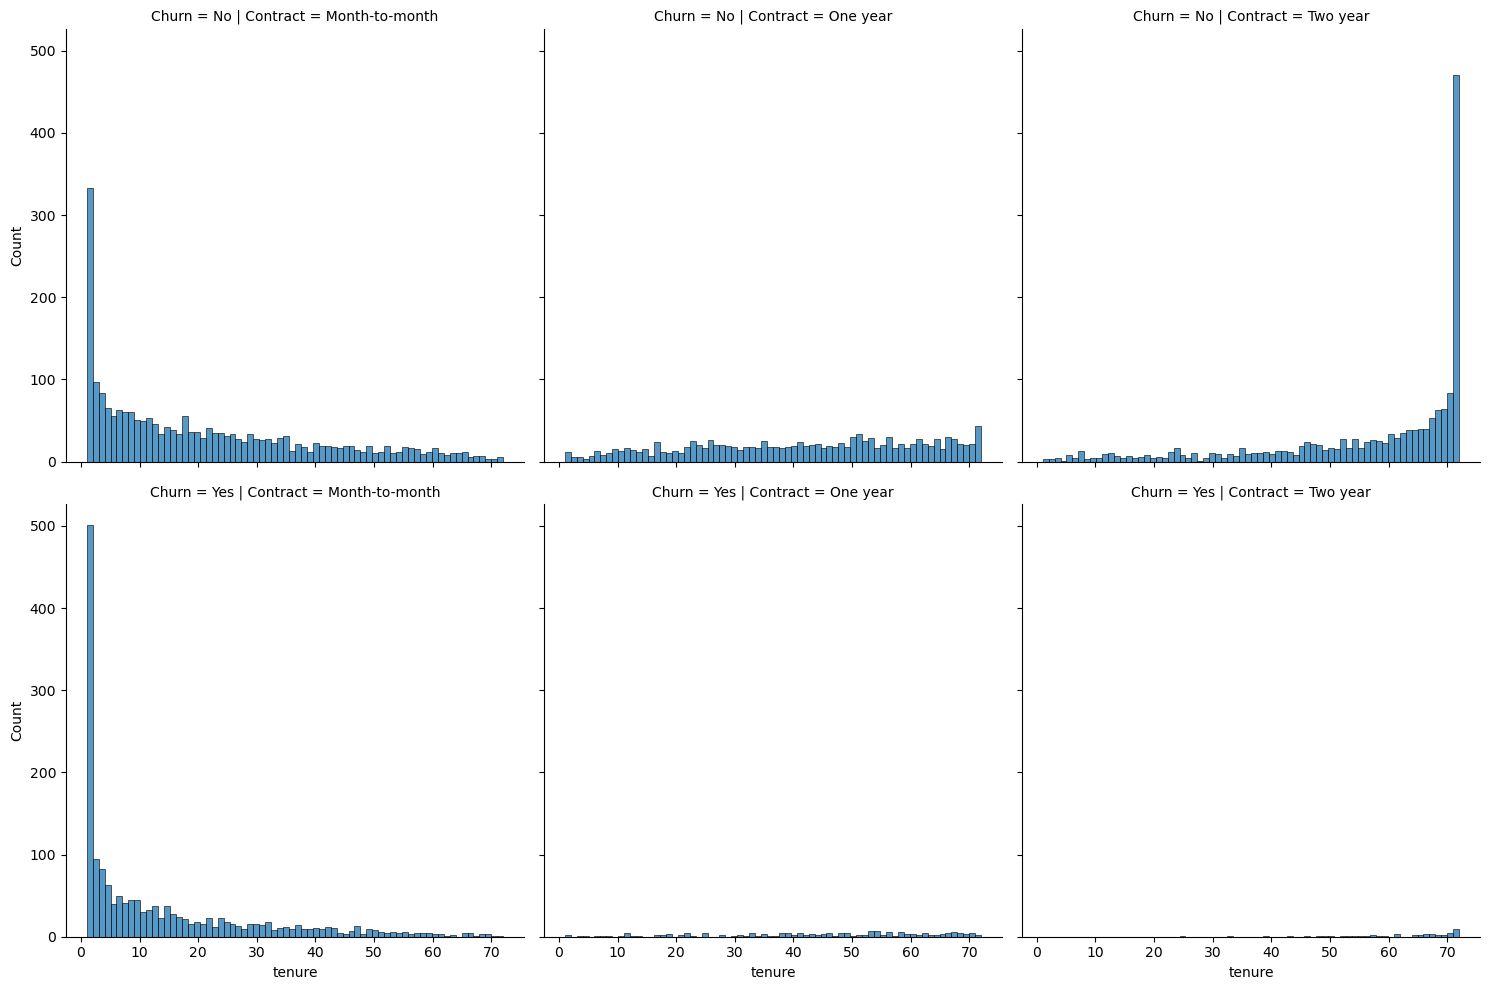

In [14]:
plt.figure(figsize=(10,3),dpi=200)
sns.displot(data=df,x='tenure',bins=70,col='Contract',row='Churn');

**Создаём сегменты.**

Разделяем признак tenure на когорты, через функцию.

Создаём более крупные сегменты в признаке.

In [59]:
def cohort(tenure):
    if tenure < 13:
        return '0-12 Months'
    elif tenure < 25:
        return '12-24 Months'
    elif tenure < 49:
        return '24-48 Months'
    else:
        return "Over 48 Months"

In [60]:
df['Tenure Cohort'] = df['tenure'].apply(cohort)

In [61]:
df.head(10)[['tenure','Tenure Cohort']]

,tenure,Tenure Cohort
0,1,0-12 Months
1,34,24-48 Months
2,2,0-12 Months
3,45,24-48 Months
4,2,0-12 Months
5,8,0-12 Months
6,22,12-24 Months
7,10,0-12 Months
8,28,24-48 Months
9,62,Over 48 Months


**Анализ Признака Ежемесячные расходы.**

Наблюдаем, что в отток уходят чаще те, у кого высокие ежемесячные расходы.

Вывод. Чем выше у абонента расходы, тем выше вероятность того, что он уйдёт.


<Axes: xlabel='MonthlyCharges', ylabel='TotalCharges'>

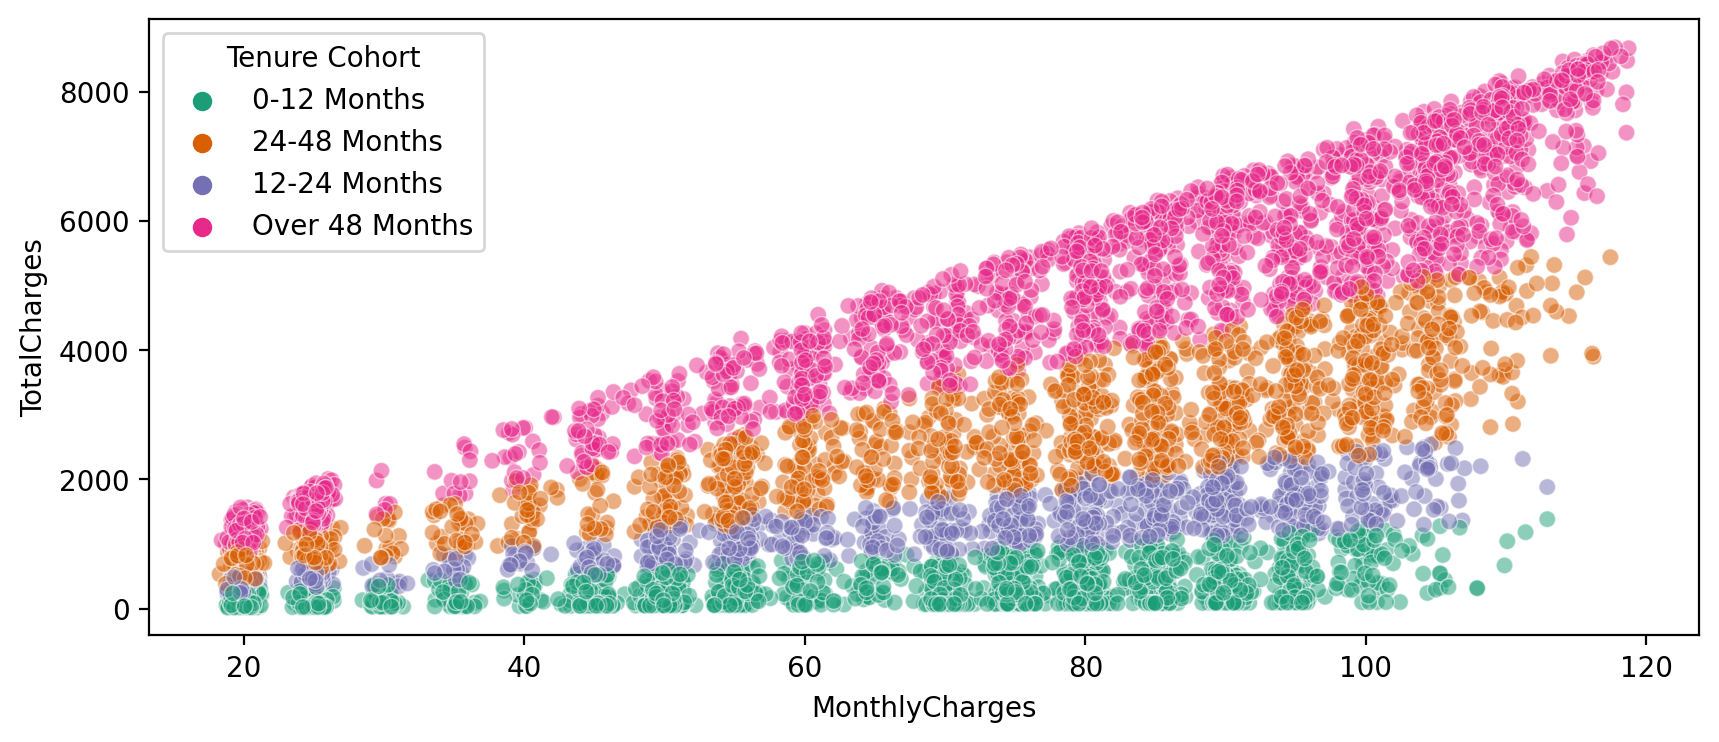

In [62]:
plt.figure(figsize=(10,4),dpi=200)
sns.scatterplot(data=df,x='MonthlyCharges',y='TotalCharges',hue='Tenure Cohort', linewidth=0.5,alpha=0.5,palette='Dark2')

**Анализ отдельных когорт.**

Наблюдаем, что люди которые пользуются услугами больше 48 месяцев, реже уходят в отток.

Если абонент пользуется услугами от 0-12 месяцев вероятность оттока выше.

Видим, что абоненты на Одно и Двух летних контрактах реже уходят в отток вне зависимости от длительности пользования услугами.

<Axes: xlabel='Tenure Cohort', ylabel='count'>

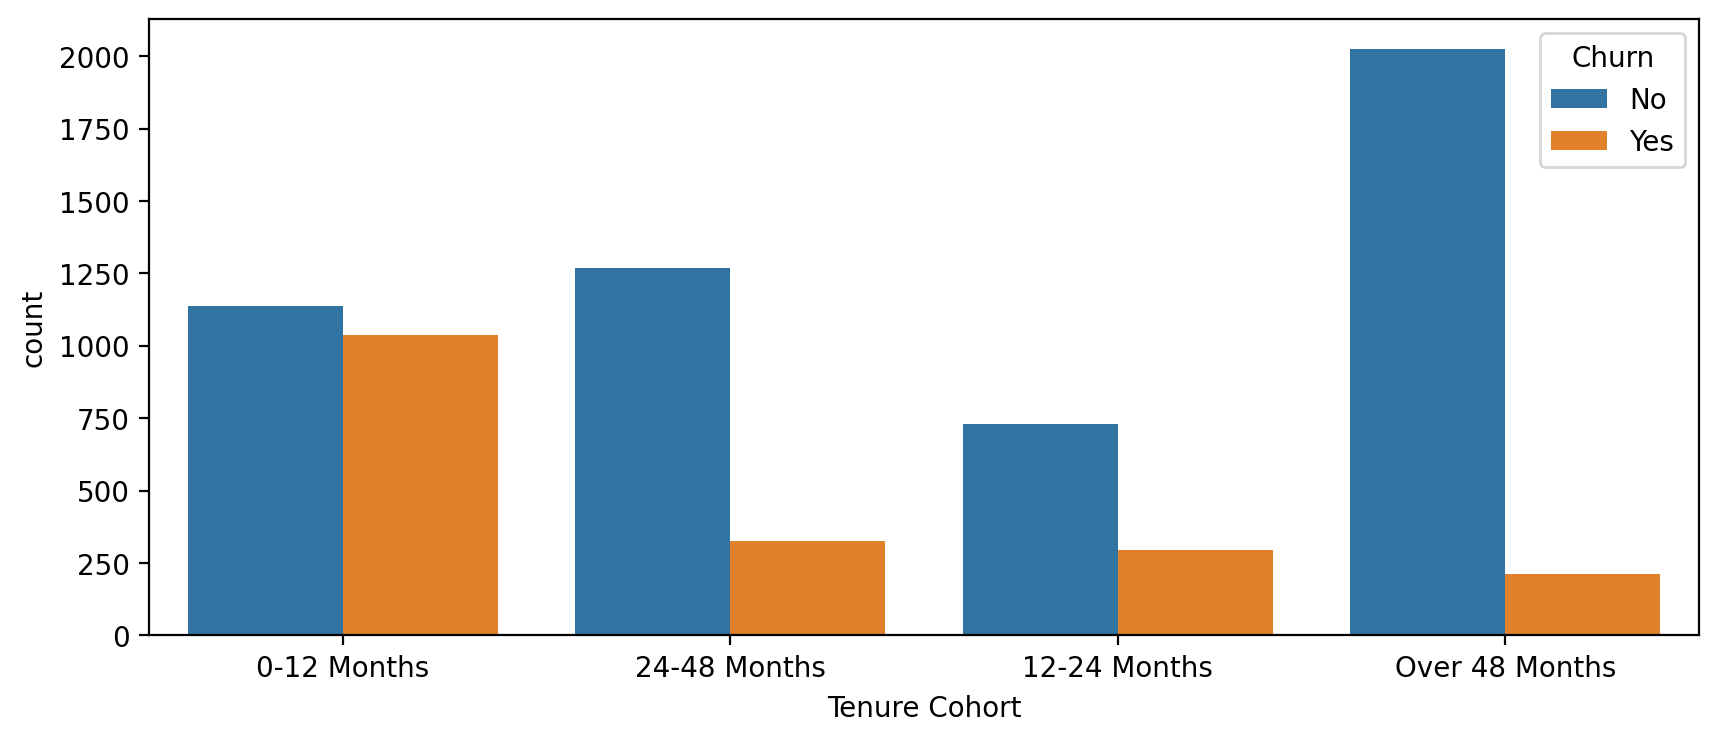

In [63]:
plt.figure(figsize=(10,4),dpi=200)
sns.countplot(data=df,x='Tenure Cohort',hue='Churn')

C:\Users\AdminPC\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x800 with 0 Axes>

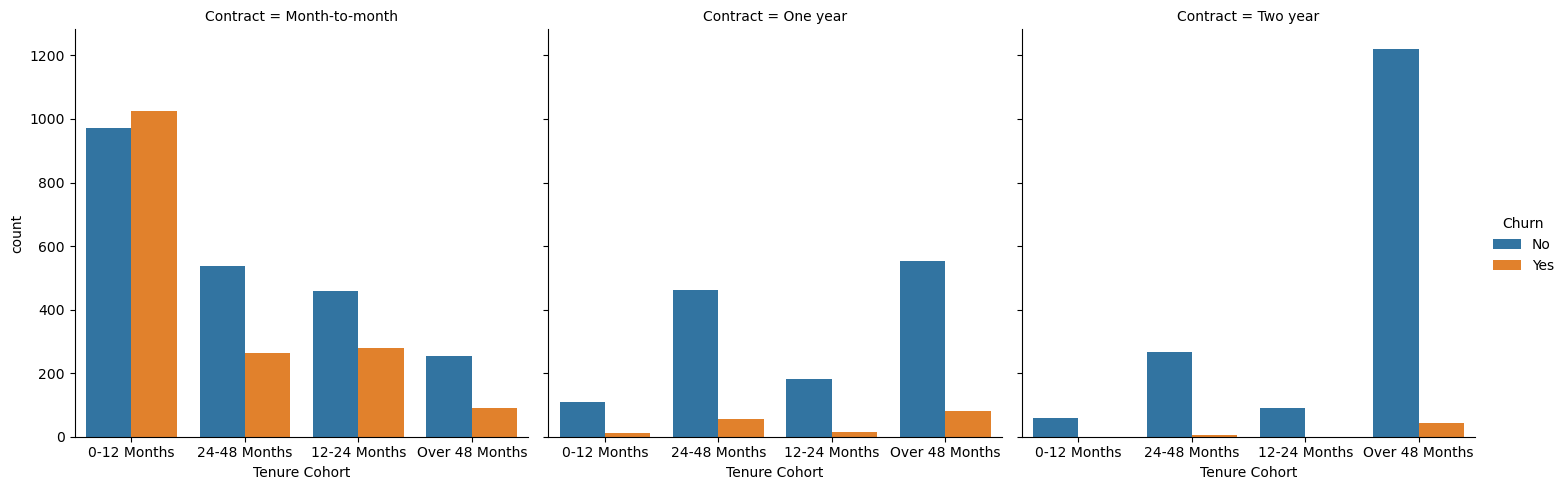

In [64]:
plt.figure(figsize=(10,4),dpi=200)
sns.catplot(data=df,x='Tenure Cohort',hue='Churn',col='Contract',kind='count')

## Задача 3. Построение предиктивных моделей.

Разделяем на признаки и Целевую переменную.

In [88]:
X = df.drop(['Churn','customerID'],axis=1)
X = pd.get_dummies(X,drop_first=True, dtype=int)

In [66]:
y = df['Churn']

In [67]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

**Первая модель.**

Используем модель Дерева решений для данных.

Модель ошиблась на 83 наблюдения. Модель утверждает, что отток не произойдёт, а он происходит.

Также модель ошиблась на 60 наблюдений. Модель утверждает, что они уйдут в отток, а они не ушли.



In [69]:
from sklearn.tree import DecisionTreeClassifier

In [129]:
from sklearn.model_selection import GridSearchCV

In [124]:
dt = DecisionTreeClassifier(max_depth=10)

In [130]:
max_depth = [1,2,3,4,5,6,7,8,9,10,15,20,30,50,70,100]

In [131]:
param_grid = {'max_depth': max_depth}

In [133]:
grid = GridSearchCV(dt,param_grid)

In [134]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(max_depth=10),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20,
                                       30, 50, 70, 100]})

In [135]:
grid.best_params_

{'max_depth': 5}

In [136]:
dt = DecisionTreeClassifier(max_depth=5)

In [140]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [142]:
preds = dt.predict(X_test)

In [143]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,classification_report

              precision    recall  f1-score   support

          No       0.86      0.89      0.87       557
         Yes       0.52      0.44      0.47       147

    accuracy                           0.80       704
   macro avg       0.69      0.66      0.67       704
weighted avg       0.79      0.80      0.79       704


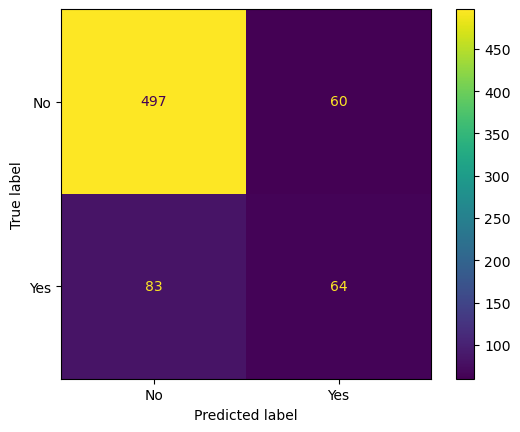

In [144]:
print(classification_report(y_test,preds), ConfusionMatrixDisplay.from_estimator(dt,X_test,y_test))

**Вторая модель.**

Используем модель Случайного леса для данных.

Модель ошиблась на 78 наблюдений. Модель утверждает, что отток не произойдёт, а он происходит.

Также модель ошиблась на 59 наблюдений. Модель утверждает, что они уйдут в отток, а они не ушли.

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [154]:
n_estimators = [64, 100, 128, 200]

In [155]:
max_features = [2, 3, 4]

In [156]:
bootstrap = [True, False]

In [157]:
oob_score = [True, False]

In [158]:
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'oob_score': oob_score}

In [160]:
rf = RandomForestClassifier()

In [162]:
grid_rf = GridSearchCV(rf, param_grid)

In [163]:
grid_rf.fit(X_train, y_train)

C:\Users\AdminPC\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\AdminPC\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\AdminPC\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AdminPC\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 417, in fit
    raise Va

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [64, 100, 128, 200],
                         'oob_score': [True, False]})

In [164]:
grid_rf.best_params_

{'bootstrap': True, 'max_features': 2, 'n_estimators': 200, 'oob_score': False}

In [166]:
rf = RandomForestClassifier(bootstrap=True, max_features=2, 
                            n_estimators=200, oob_score=False)

In [168]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_features=2, n_estimators=200)

In [169]:
preds = rf.predict(X_test)

              precision    recall  f1-score   support

          No       0.86      0.89      0.88       557
         Yes       0.54      0.47      0.50       147

    accuracy                           0.81       704
   macro avg       0.70      0.68      0.69       704
weighted avg       0.80      0.81      0.80       704


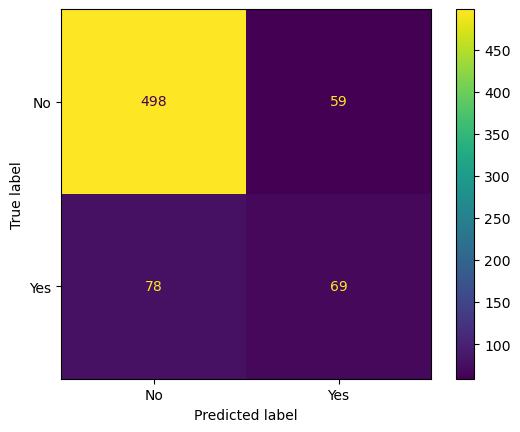

In [170]:
print(classification_report(y_test,preds), ConfusionMatrixDisplay.from_estimator(rf,X_test,y_test))

**Третья модель.**
Модель Адаптивного бустинга.


In [82]:
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier

In [83]:
ada_model = AdaBoostClassifier()

In [84]:
ada_model.fit(X_train,y_train)

AdaBoostClassifier()

In [85]:
preds = ada_model.predict(X_test)

              precision    recall  f1-score   support

          No       0.87      0.90      0.89       557
         Yes       0.57      0.50      0.53       147

    accuracy                           0.82       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.81      0.82      0.81       704


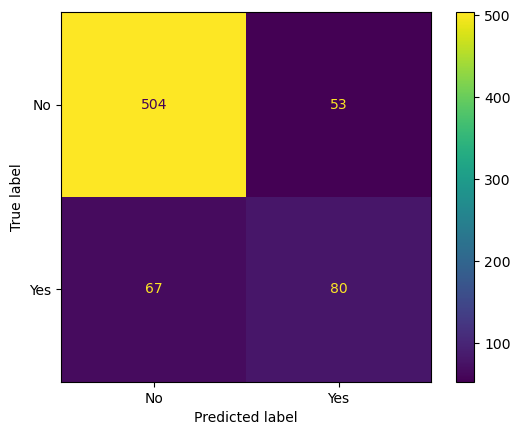

In [175]:
print(classification_report(y_test,preds), ConfusionMatrixDisplay.from_estimator(ada_model,X_test,y_test))

**Четвёртая модель.**
Модель Градиентного бустинга.


In [171]:
grad_model = GradientBoostingClassifier()

In [172]:
grad_model.fit(X_train, y_train)

GradientBoostingClassifier()

In [173]:
preds = grad_model.predict(X_test)

              precision    recall  f1-score   support

          No       0.87      0.90      0.89       557
         Yes       0.57      0.50      0.53       147

    accuracy                           0.82       704
   macro avg       0.72      0.70      0.71       704
weighted avg       0.81      0.82      0.81       704


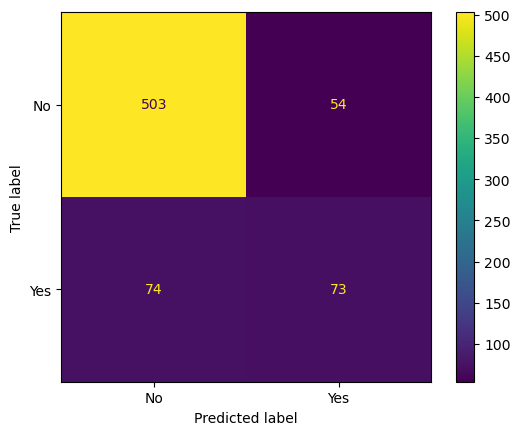

In [176]:
print(classification_report(y_test,preds), ConfusionMatrixDisplay.from_estimator(grad_model,X_test,y_test))